# Recommendation System

In [ ]:
# Core data processing
import numpy as np
import pandas as pd
import re

# Database
from sqlalchemy import create_engine

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Machine Learning - Core
from catboost import CatBoostClassifier

# Machine Learning - Scikit-learn components
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lefukuro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lefukuro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [194]:
# DATA LOADING FROM DATABASE

# Purpose: Load and combine user, post, and interaction data from PostgreSQL

#  user_data: User demographic information
#  post_text_df: Post content 
#  feed_data: User interactions with posts (likes/views)

engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

users = pd.read_sql("SELECT * FROM public.user_data;", con=engine)
posts_text = pd.read_sql("SELECT * FROM public.post_text_df;", con=engine)
uniq_act = pd.read_sql("SELECT DISTINCT ON (user_id, target, feed_data.action) user_id, post_id, public.feed_data.action, timestamp, target FROM public.feed_data;", con=engine)
acts = pd.read_sql("SELECT * FROM public.feed_data WHERE target=1 ORDER BY random() LIMIT 800000;", con=engine)

# Combine interaction data: unique actions + sampled positive interactions
all_actions = pd.concat([uniq_act, acts], axis=0)
df = pd.merge(users, all_actions, on='user_id',how='left')

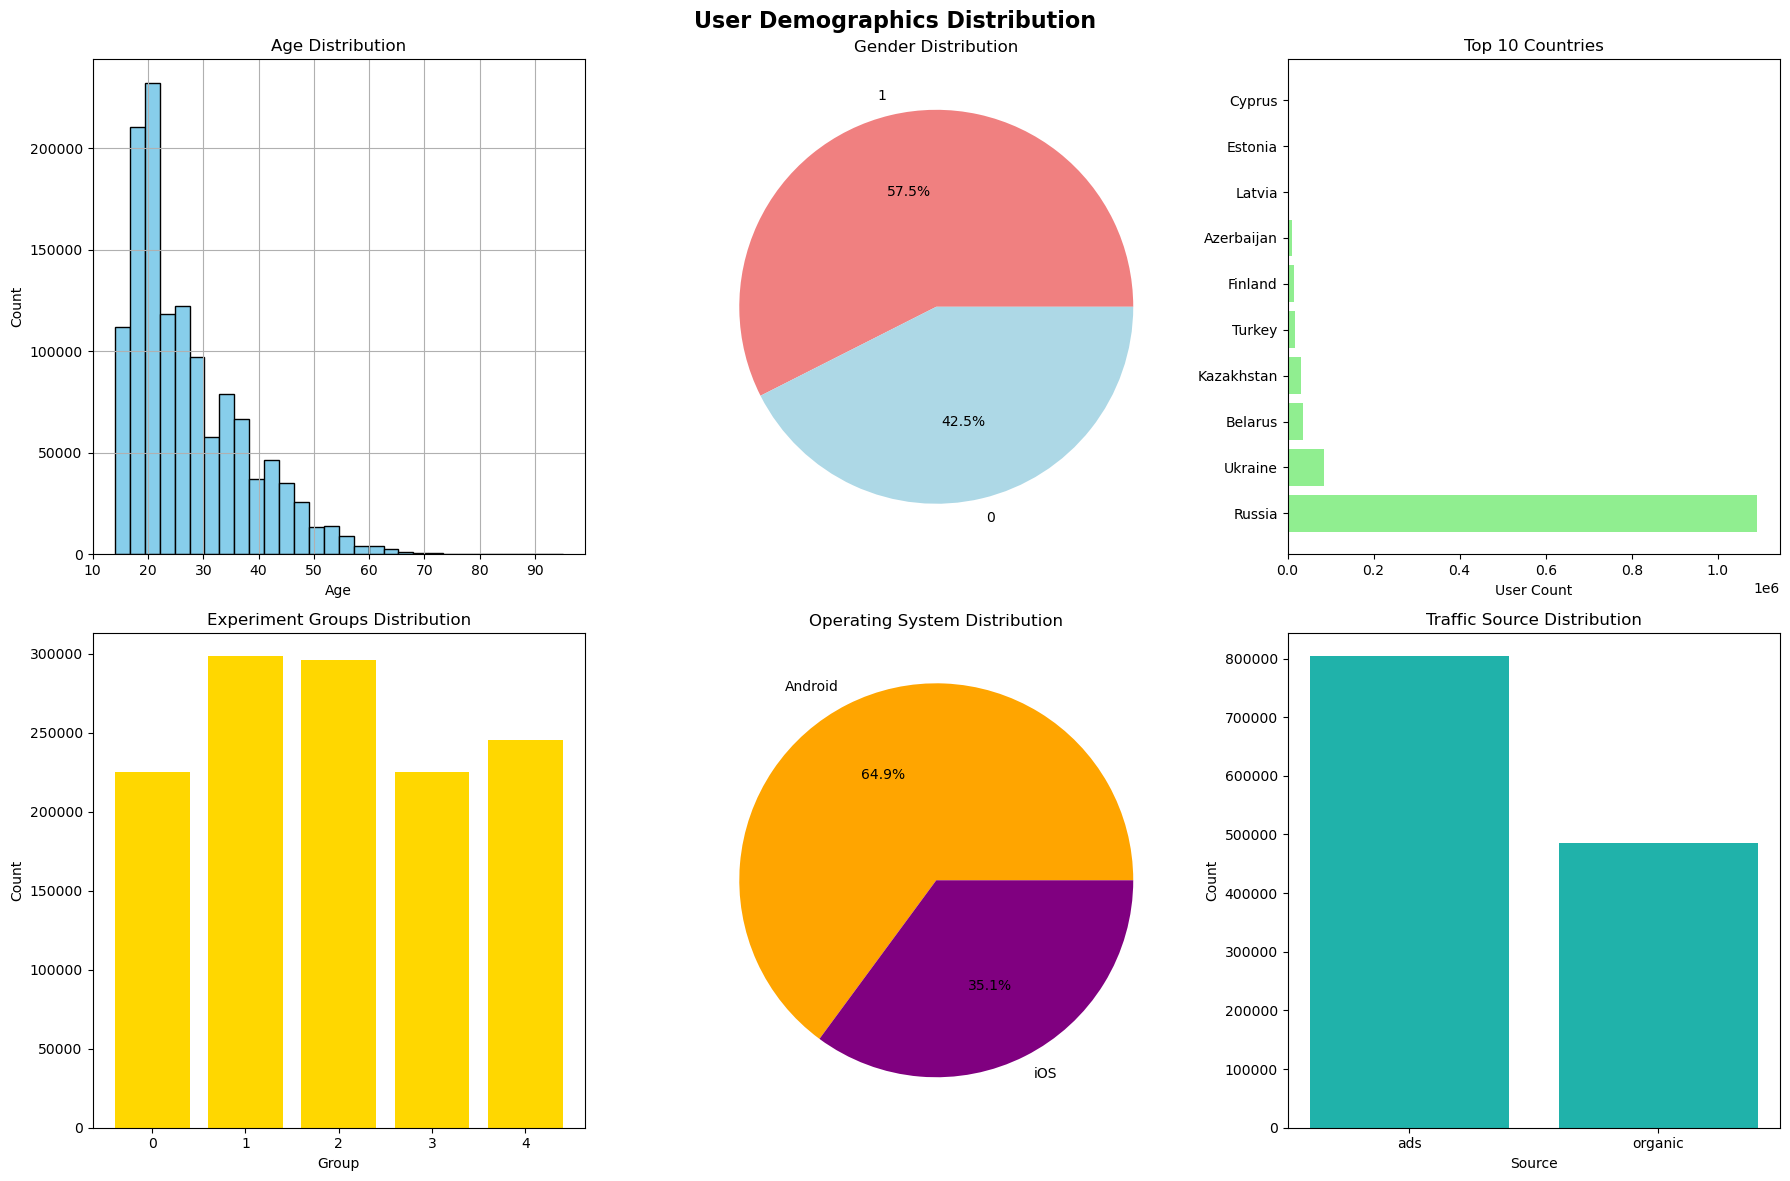

Age statistics:
Mean: 27.2, Median: 24.0
Min: 14, Max: 95
Gender ratio: {1: 740978, 0: 548631}


In [195]:
# User demographics analysis

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('User Demographics Distribution', fontsize=16, fontweight='bold')

# Age distribution
df['age'].hist(bins=30, ax=axes[0,0], color='skyblue', edgecolor='black')
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Count')

# Gender distribution
gender_counts = df['gender'].value_counts()
axes[0,1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
axes[0,1].set_title('Gender Distribution')

# Country distribution
country_top10 = df['country'].value_counts().head(10)
axes[0,2].barh(range(len(country_top10)), country_top10.values, color='lightgreen')
axes[0,2].set_yticks(range(len(country_top10)))
axes[0,2].set_yticklabels(country_top10.index)
axes[0,2].set_title('Top 10 Countries')
axes[0,2].set_xlabel('User Count')

# Experiment groups
exp_counts = df['exp_group'].value_counts()
axes[1,0].bar(exp_counts.index, exp_counts.values, color='gold')
axes[1,0].set_title('Experiment Groups Distribution')
axes[1,0].set_xlabel('Group')
axes[1,0].set_ylabel('Count')

# OS distribution
os_counts = df['os'].value_counts()
axes[1,1].pie(os_counts.values, labels=os_counts.index, autopct='%1.1f%%', colors=['orange', 'purple'])
axes[1,1].set_title('Operating System Distribution')

# Traffic source
source_counts = df['source'].value_counts()
axes[1,2].bar(source_counts.index, source_counts.values, color='lightseagreen')
axes[1,2].set_title('Traffic Source Distribution')
axes[1,2].set_xlabel('Source')
axes[1,2].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Demographic statistics
print(f"Age statistics:")
print(f"Mean: {df['age'].mean():.1f}, Median: {df['age'].median():.1f}")
print(f"Min: {df['age'].min()}, Max: {df['age'].max()}")
print(f"Gender ratio: {gender_counts.to_dict()}")


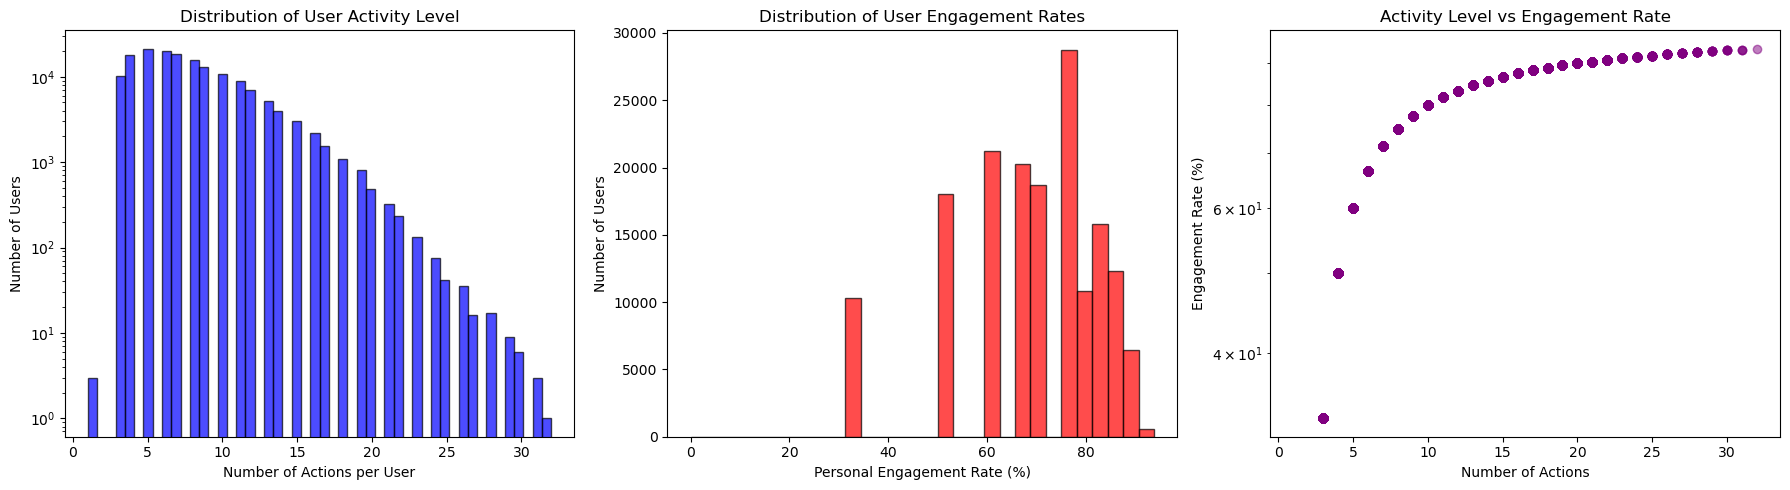

User Behavior Statistics:
Average actions per user: 7.9
Median actions per user: 7.0
Most active user: 32 actions
Average personal engagement rate: 68.87%
Correlation (activity vs engagement): 0.867


In [196]:
# User behavior analysis
fig.suptitle('Content and Engagement Analysis', fontsize=16, fontweight='bold')

# User activity levels
user_activity = df.groupby('user_id').size()
user_engagement = df.groupby('user_id')['target'].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# User activity distribution
axes[0].hist(user_activity, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of User Activity Level')
axes[0].set_xlabel('Number of Actions per User')
axes[0].set_ylabel('Number of Users')
axes[0].set_yscale('log')

# User engagement distribution
axes[1].hist(user_engagement * 100, bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of User Engagement Rates')
axes[1].set_xlabel('Personal Engagement Rate (%)')
axes[1].set_ylabel('Number of Users')

# Activity vs Engagement scatter
axes[2].scatter(user_activity, user_engagement * 100, alpha=0.5, color='purple')
axes[2].set_title('Activity Level vs Engagement Rate')
axes[2].set_xlabel('Number of Actions')
axes[2].set_ylabel('Engagement Rate (%)')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

print("User Behavior Statistics:")
print(f"Average actions per user: {user_activity.mean():.1f}")
print(f"Median actions per user: {user_activity.median():.1f}")
print(f"Most active user: {user_activity.max()} actions")
print(f"Average personal engagement rate: {user_engagement.mean() * 100:.2f}%")
print(f"Correlation (activity vs engagement): {user_activity.corr(user_engagement):.3f}")

In [197]:
# Display information about the DataFrames
print("Data Info:")
df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289609 entries, 0 to 1289608
Data columns (total 12 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   user_id    1289609 non-null  int64         
 1   gender     1289609 non-null  int64         
 2   age        1289609 non-null  int64         
 3   country    1289609 non-null  object        
 4   city       1289609 non-null  object        
 5   exp_group  1289609 non-null  int64         
 6   os         1289609 non-null  object        
 7   source     1289609 non-null  object        
 8   post_id    1289609 non-null  int64         
 9   action     1289609 non-null  object        
 10  timestamp  1289609 non-null  datetime64[ns]
 11  target     1289609 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 118.1+ MB


In [198]:
# Calculate overall post popularity metrics
post_popularity = df.groupby('post_id').agg({
    'target': ['count', 'sum', 'mean']  # count = total views, sum = positive interactions, mean = positive ratio
}).round(3)

# Rename columns for better readability
post_popularity.columns = [
    'total_interactions', 
    'positive_interactions', 
    'positive_ratio'
]

# Sort posts by most positive interactions (descending order)
post_popularity = post_popularity.sort_values('positive_interactions', ascending=False)

print("Overall post popularity statistics:")
print(post_popularity.head(10))

# Merge popularity metrics back to the main dataframe
df = pd.merge(df, post_popularity, on='post_id', how='left')

# Drop 'action' column as it's redundant with 'target'
df = df.drop('action', axis=1)

# Analyze user interactions with topics
topic_interactions = all_actions.merge(posts_text[['post_id', 'topic']], left_on='post_id', right_on='post_id', how='left')

# Create user-topic interaction matrix (users as rows, topics as columns)
topic_interactions = topic_interactions.groupby(['user_id', 'topic']).size().unstack(fill_value=0)

Overall post popularity statistics:
         total_interactions  positive_interactions  positive_ratio
post_id                                                           
1634                    513                    395           0.770
3433                    503                    385           0.765
1580                    482                    382           0.793
1520                    492                    382           0.776
1106                    488                    380           0.779
1304                    504                    380           0.754
1542                    475                    379           0.798
1361                    488                    372           0.762
1437                    478                    372           0.778
1578                    474                    371           0.783


In [200]:
# Process categorical columns

for col in df.loc[:, df.dtypes==object].columns:
    if df[col].nunique() < 5:
        one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)
    else:
        mean_target = df.groupby(col)['target'].mean()
        df[col] = df[col].map(mean_target)

In [201]:
# Text preprocessing and cleaning

# Initialize NLP tools
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    """
    Clean and preprocess text data by:
    - Converting to lowercase
    - Removing special characters and punctuation
    - Removing stopwords
    - Handling emojis
    """
    
    text = text.lower()  
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    
    for p in punctuations:
        text = text.replace(p,'')
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    def remove_emojis(text):
        return emoji.demojize(text)
   
    text = " ".join(text)
    
    return text

# Apply text cleaning to all posts
posts_text['text'] = posts_text['text'].apply(lambda x: clean_text(x))

# Create TF-IDF matrix for text feature extraction
tfidf = TfidfVectorizer(max_features = 300)  
tfidf_matrix = tfidf.fit_transform(posts_text['text'].fillna('unknown'))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Reset index for merge later
tfidf_df.reset_index(drop=True, inplace=True)
posts_text.reset_index(drop=True, inplace=True)

In [202]:
# Data standardization for TF-IDF features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfidf_df)

# Apply PCA (300 features -> 50 components)
pca = PCA(n_components=50) 
X_pca = pca.fit_transform(X_scaled)

# Convert PCA results to DataFrame with descriptive column names
X_pca_df = pd.DataFrame(X_pca).add_prefix('PCA_')

# Extract PCA components (loadings) to analyze feature importance
components = pca.components_

# Create DataFrame showing how original features contribute to each principal component
importance_df = pd.DataFrame(components, columns=tfidf.get_feature_names_out()) 

# Calculate overall feature importance by summing absolute loadings across all components
importance_scores = importance_df.abs().sum(axis=0).sort_values(ascending=False)

print(f"Top 10 most important words by PCA loading:")
print(importance_scores.head(10))




Top 10 most important words by PCA loading:
phone      3.436198
mobile     3.337969
budget     3.315535
low        3.134163
ive        3.027515
sure       3.003848
seen       2.910011
im         2.887305
service    2.872987
british    2.823174
dtype: float64


In [203]:
# Apply K-Means clustering to group similar text
kmeans = KMeans(n_clusters=100, random_state=42).fit(X_pca)

# Standardize PCA features
KMeans_scaled = scaler.fit_transform(X_pca)

# Assign cluster labels to each post as new categorical feature
posts_text['kmeans_pca'] = kmeans.predict(X_pca)

In [204]:
# Create new feature: text length (can indicate post complexity or detail level)
posts_text['text_length'] = posts_text['text'].apply(len)

# One-hot encoding for 'topic' column
one_hot = pd.get_dummies(posts_text['topic'], prefix='topic', drop_first=True)

# Combine all post features into final dataset
post_final = pd.concat((posts_text.drop('topic', axis=1), one_hot), axis=1)

In [205]:
# Merge all feature sets into final dataset
df_cat = pd.merge(df, topic_interactions, on='user_id', how='left')
df_cat = pd.merge(df_cat, post_final, on='post_id', how='left')

# Sort by timestamp to maintain chronological order for time-based analysis
df_sorted = df_cat.sort_values('timestamp').reset_index(drop=True)

### Feature selection based on previous model analysis 
The following features were identified as having zero importance (0.0000) 
during initial model training and are removed to reduce dimensionality

In [206]:
# Drop zero-importance features
zero_importance_features = ['topic_covid', 'source_organic', 'os_iOS']
df_sorted = df_sorted.drop(zero_importance_features, axis=1)

In [207]:
# Data type optimization for memory efficiency and model compatibility

# Select only numeric columns for type conversion (exclude categorical/text)
numeric_columns = df_cat.select_dtypes(include=['int64', 'float64']).columns

print(f"Converting {len(numeric_columns)} numeric columns to float32:")

# Convert numeric columns to float32 to reduce memory usage
df_cat[numeric_columns] = df_cat[numeric_columns].astype('float32')

# Convert timestamp to datetime format for proper time series analysis
df_cat['timestamp'] = pd.to_datetime(df_cat['timestamp'])

Converting 19 numeric columns to float32:


In [ ]:
# Prepare features and target for model training

# Features: exclude target, text (already processed), and ID columns
X = df_sorted.drop(['target', 'text', 'user_id', 'post_id'], axis=1)
y = df_sorted['target']

# Store IDs for later analysis and interpretation
user_ids = df_sorted['user_id']
post_ids = df_sorted['post_id']

# Split data into training and test sets while preserving user and post IDs
X_train, X_test, y_train, y_test, user_train, user_test, post_train, post_test = train_test_split(X, y, user_ids, post_ids, test_size=0.2, random_state=42)

In [208]:
def train_catboost(X_train, y_train, params=None, random_state=42):
    """
    Train CatBoost classifier with hyperparameter tuning using RandomizedSearchCV
    
    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training target
    params : dict, optional
        Hyperparameter grid for tuning. If None, uses default grid
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    best_model : CatBoostClassifier
        Trained model with best found parameters
    """
    
    # Initialize base CatBoost model
    catboost_model = CatBoostClassifier(
        loss_function='Logloss',  # Binary classification loss
        verbose=100,              # Progress logging every 100 iterations
        random_state=random_state # Reproducibility
    )
    
    # Default hyperparameter grid for tuning
    if params is None:
        params = {
            'depth': [4, 6, 8],               
            'learning_rate': [0.01, 0.1, 0.2], 
            'iterations': [100, 200],
            'l2_leaf_reg': [1, 3, 5],
        }

    # Hyperparameter tuning with cross-validation
    randomized_search = RandomizedSearchCV(
        catboost_model, 
        params, 
        n_iter=10,
        scoring='roc_auc', 
        cv=3,
        n_jobs=-1,
        random_state=random_state
    )
    
    # Train model with hyperparameter search
    randomized_search.fit(X_train, y_train)    

    # Display tuning results
    print(f"Best parameters: {randomized_search.best_params_}")
    print(f"Best ROC-AUC (CV): {randomized_search.best_score_:.4f}")
    
    return randomized_search.best_estimator_

In [209]:
# Reduce training set size for computational efficiency during development
# Using 800,000 samples instead of full dataset for faster iteration
X_train_final = X_train.iloc[:800000]
y_train_final = y_train.iloc[:800000]

# Train CatBoost model with optimized hyperparameters
model = train_catboost(X_train_final, y_train_final)

0:	learn: 0.6619186	total: 413ms	remaining: 40.8s
0:	learn: 0.6897642	total: 719ms	remaining: 2m 23s
0:	learn: 0.6618582	total: 712ms	remaining: 1m 10s
0:	learn: 0.6897870	total: 726ms	remaining: 2m 24s
0:	learn: 0.6612805	total: 620ms	remaining: 2m 3s
0:	learn: 0.6613579	total: 747ms	remaining: 2m 28s
0:	learn: 0.6610731	total: 773ms	remaining: 2m 33s
0:	learn: 0.6615560	total: 500ms	remaining: 49.5s
99:	learn: 0.5122821	total: 16.9s	remaining: 0us
99:	learn: 0.5123841	total: 17.7s	remaining: 0us
99:	learn: 0.5136094	total: 18.2s	remaining: 0us
0:	learn: 0.6897944	total: 292ms	remaining: 58.1s
0:	learn: 0.6899343	total: 229ms	remaining: 45.6s
0:	learn: 0.6899309	total: 122ms	remaining: 24.3s
100:	learn: 0.5088086	total: 21.8s	remaining: 21.4s
100:	learn: 0.5082463	total: 22.3s	remaining: 21.8s
100:	learn: 0.5471090	total: 22.6s	remaining: 22.2s
100:	learn: 0.5467605	total: 22.8s	remaining: 22.3s
100:	learn: 0.5083299	total: 22.5s	remaining: 22s
100:	learn: 0.5561467	total: 14.9s	remai

In [210]:
def calculate_dcg5(model, X_test, y_test, user_ids, post_ids, k=5):
    """
    Calculate Discounted Cumulative Gain for recommendation system
    
    Parameters:
    -----------
    model : trained model
        Machine learning model with predict_proba method
    X_test : DataFrame
        Test features
    y_test : Series
        True labels
    user_ids : Series
        User identifiers for grouping
    post_ids : Series
        Post identifiers
    k : int
        Number of top recommendations to consider (default: 5)
        
    Returns:
    --------
    mean_dcg : float
        Average DCG score across all users
    """
    
    # Create test dataset with predictions and metadata
    test_data = X_test.copy()
    test_data['pred'] = model.predict_proba(X_test)[:, 1]  # Prediction probabilities
    test_data['target'] = y_test                           # True labels
    test_data['user_id'] = user_ids                        # User identifiers
    test_data['post_id'] = post_ids                        # Post identifiers
    
    users_dcgs = []  # Store DCG scores for each user
    
    # Calculate DCG for each user individually
    for user in test_data['user_id'].unique():
        # Get all interactions for current user
        user_data = test_data[test_data['user_id'] == user]
        
        # Sort posts by predicted relevance (descending)
        user_data = user_data.sort_values('pred', ascending=False)
        
        # Select top-K recommendations
        top_k_posts = user_data.head(k)
        
        # Calculate DCG for this user's recommendations
        dcg = 0
        for position, (_, row) in enumerate(top_k_posts.iterrows(), 1):
            relevance = row['target']           # True relevance (0 or 1)
            discount = 1 / np.log2(position + 1)  # Position discount factor
            dcg += relevance * discount
        
        users_dcgs.append(dcg)
    
    # Return average DCG across all users
    mean_dcg = np.mean(users_dcgs)
    print(f"Average DCG@{k}: {mean_dcg:.4f} (across {len(users_dcgs)} users)")
    
    return mean_dcg

In [ ]:
# Evaluate model performance using DCG@5 metric
# DCG measures recommendation quality by considering:
# - Relevance of recommended items
# - Position in the recommendation list (higher positions weighted more)
dcg_score = calculate_dcg5(model, X_test, y_test, user_ids, post_ids, k=5)
print(f"DCG@5: {dcg_score:.4f}")

Average DCG@5: 1.1687 (across 126815 users)
DCG@5: 1.1687


In [219]:
# Calculate theoretical maximum DCG for test data
def calculate_max_dcg5(y_test, user_ids, k=5):
    """
    Calculate theoretical maximum DCG@5 for the test dataset
    
    Parameters:
    -----------
    y_test : Series
        True relevance labels
    user_ids : Series  
        User identifiers for grouping
    k : int
        Number of top items to consider
        
    Returns:
    --------
    max_dcg : float
        Maximum achievable DCG@5 given the available relevant items
    """
        
    test_data = pd.DataFrame({'target': y_test, 'user_id': user_ids})
    max_dcgs = []
    
    for user in test_data['user_id'].unique():
        user_data = test_data[test_data['user_id'] == user]['target']

        # Sort by true relevance 
        ideal_order = sorted(user_data, reverse=True)[:k]
        
        dcg = 0
        for position, rel in enumerate(ideal_order, 1):
            dcg += rel * (1 / np.log2(position + 1))
        max_dcgs.append(dcg)
    
    return np.mean(max_dcgs)

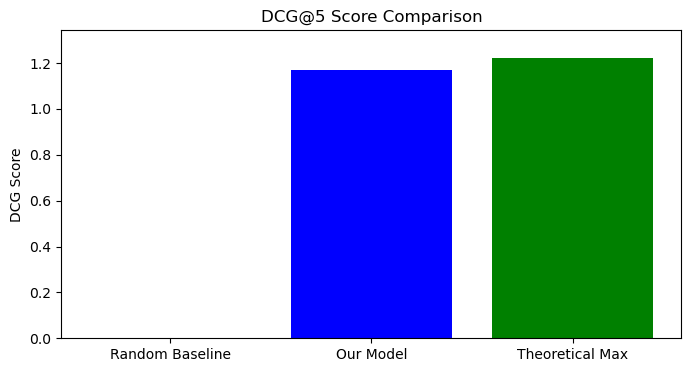

Our model: 1.1687
Theoretical maximum: 1.2207
Efficiency: 95.7% of ideal performance


In [220]:
# Calculate theoretical maximum DCG for test data
max_dcg = calculate_max_dcg5(y_test, user_test, k=5)

# Visualization of DCG score comparison
metrics = {
    'Random Baseline': 0.0,
    'Our Model': dcg_score,
    'Theoretical Max': max_dcg  # Исправлено!
}

plt.figure(figsize=(8, 4))
plt.bar(metrics.keys(), metrics.values(), color=['red', 'blue', 'green'])
plt.title('DCG@5 Score Comparison')
plt.ylabel('DCG Score')
plt.ylim(0, max(metrics.values()) * 1.1)
plt.show()

print(f"Model: {dcg_score:.4f}")
print(f"Theoretical maximum: {max_dcg:.4f}")
print(f"Efficiency: {(dcg_score / max_dcg * 100):.1f}% of ideal performance")

In [222]:
# Analyze feature importance to understand model decision factors

# Extract feature importance scores from trained CatBoost model
feature_importance = model.get_feature_importance()

# Get feature names from the model
feature_names = model.feature_names_

# Create sorted DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df)


                  feature  importance
1                     age   16.388554
12                  movie   14.221069
10                  covid   10.335169
7   positive_interactions    6.892968
6      total_interactions    6.813620
3                    city    6.785631
14                  sport    6.766818
8          positive_ratio    6.160573
13               politics    5.105779
5               timestamp    4.705703
9                business    3.635783
11          entertainment    3.283827
15                   tech    2.516603
4               exp_group    2.439080
17            text_length    0.846796
21            topic_sport    0.695690
16             kmeans_pca    0.680173
19            topic_movie    0.668584
20         topic_politics    0.411132
0                  gender    0.316036
2                 country    0.195503
22             topic_tech    0.101804
18    topic_entertainment    0.033103
